# How to read and understand the xml

## The xml files

In MuJoCo (the physics engine NeuroMechFly relies on), a xml file is used to describe the skeleton of the fly. In our implementation, the xmls define:
- The skeleton of the fly: How bodies/geometries and joints are arranged to build a fly
- The actuators: Different kind of object that are used to apply forces to the model (position actuator to move joints, adhesion actuators to add adhesion).


The xml can also be modified in the code and that is how you will interact but for now let's walk through some key aspects of the xml file. 

**Note that we have different xml that use different kinematic chain as the order of joint matters.**

Here is an example of a kinematic chain for one leg lets walk through it together:
<p align="center">
    <img src="source/xml_kinematic_chain.png" width="2000" style="background-color: white;"/>
</p>


At the top of this block of code is defined the worldbody it is used for the top-level body it cannot have child elements inertial and joint, and also cannot have any attributes. It corresponds to the origin of the world frame, within which the rest of the kinematic tree is defined.
Attached to the woldbody, there is a regular body: the Thorax, the Thorax has a position (relative to the worldbody) and an orientation given by the quat parameter. The Thorax body has 7 direct children visible in this block of code (but many more in total: 6 legs, head, abdomen, halteres, ...):
- A geometry: Thorax 
- Two other bodies: 
    - A1 (the first section of the abdomen)
    - LFCoxa (the first segment of the left front leg) 
    - L/RWing
    - L/RHaltere

### The Thorax geometry:
Geometries determine the appearance and collision properties of the body. At compile time they can also determine the inertial properties of the body, depending on the presence of the inertial element and the setting of the inertiafromgeom attribute of compiler. To get a sense of all the attributes a geometry can have go through the [MuJoCo documentation about geometries](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-geom)

### Next bodies in the kinematic chain:
As stated earlier many other bodies are attached to the Thorax body. Those define the next body in the kinematic chain. The position of the next body is given in relative position with respect to the parent body. If we focus on the Coxa body (line 121), the body is offset by -0.16059550642967224 0.1715880036354065 -0.23021531105041504 with respect to the origin of the Thorax body. By construction (this is a choice that we made) the origin of the body is in most cases the position of the joint between the parent and the child body (here the Thorax coxa joint).
The LFCoxa body has 5 different children:
- 3 joints that defines the three degrees of freedom of the Thorax-Coxa joint. As discussed earlier those are not offset to the parents as the LFCoxa body is located at the location of the joint (for more information regarding the joints have a look at the [MuJoCo documentation](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-joint)). Note that the order of the joints matters. When actuated or when reading out of a sensor now that the first dof will be applied/readout followed by the second and the third. This matters as depending on the order different configurations of the children body will be obtained. 
- The LFCoxa geometry. Same structure and role as before. We might want to spend more time discussing the **mesh** attribute of the geometry. Meshes are used to describe the complex shapes of objects. Here this relies on the CT scan of the fly obtained for the [NeuroMechFly paper](https://www.nature.com/articles/s41592-022-01466-7#Sec39). The geometries are **not** offset, this is because the origin of each files containing the mesh is the location of the joint. As the origin of the bodies are also located at the joint location, there is no need for an offset. **Those are all convention we used, it is important that you are aware of those when adding joints, sensors and actuators.**
- The LFFemur body. The next body in the kinematic chain.

### Camera and lighting:
<p align="center">
    <img src="source/xml_cameras.png" width="2000" style="background-color: white;"/>
</p>

Cameras and lighting can be added to bodies. In this code samples cameras and lighting are added to the worldbody. In the code it is from those cameras that we are rendering. More information about the [cameras](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-camera) and the [lighting](https://mujoco.readthedocs.io/en/stable/XMLreference.html#body-light) can be found in the xml documentation. Especially important is the mode that defines how the camera moves with respect to the body it is attached to.

### Actuators:
<p align="center">
    <img src="source/xml_actuators.png" width="2000" style="background-color: white;"/>
</p>

Actuators are applying forces to the model. Many type of actuators can be used in MuJoCo those are summarized in the [documentation](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuators).
We are particularly interested to [position actuators](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-position) and [adhesion actuators](https://mujoco.readthedocs.io/en/stable/XMLreference.html#actuator-adhesion).

### Sensors:
No sensors are added directly to the xml file. More information about sensors can be found in the [MuJoco documentation](https://mujoco.readthedocs.io/en/stable/XMLreference.html#sensor).

These are all the relevant information regarding the xml. More general and precise information can be found in the [MuJoCo xml documentation](https://mujoco.readthedocs.io/en/stable/XMLreference.html).

## Modifying the xml through the code:

While the most basic features of NeuroMechFly must be defined in the .xml more flexibility can be obtained by defining some features in the code. In particular it is interesting for a user to be able to use new sensors, actuators, cameras, bodies and geometries as well as modifying the relevant attributes of those features. All those addition through the code are performed in the __init__ of the NeuroMechFly class.
Here are a few examples showing how we can add new joints, actuators and sensors to NeuroMechFly.

Here is the line of code that builds the physics from the xml. After this point if the model is modified the change will not apply.

```Python
self.physics = mjcf.Physics.from_mjcf_model(self.arena_root)
```

Before that, the xml defining the fly was modified to add actuators, sensors and change the joints properties among other. The fly was then spawn into the arena that was fully defined through the code. Lets look in more details how actuators, sensors and joints are added/(modified and how those functions could be overwritten to add new actuators).

In [16]:
from flygym.mujoco import Parameters, NeuroMechFly

### Add joints

While in the new api one can initialize a fly and add joint before the physics is built, this not possible in the old API. For that reason, we have to go for a less elegant solution. 

For now we propose to override the function modifying the joint's properties: 

```Python
def _set_joints_stiffness_and_damping(self):
    for joint in self.model.find_all("joint"):
        if joint.name in self.actuated_joints:
            joint.stiffness = self.sim_params.joint_stiffness
            joint.damping = self.sim_params.joint_damping
        else:
            joint.stiffness = self.sim_params.non_actuated_joint_stiffness
            joint.damping = self.sim_params.non_actuated_joint_damping
```

Let's modify this function so that it adds a new joint to NeuroMechFly


In [17]:
class AbdomenNMF(NeuroMechFly):
    def _set_joints_stiffness_and_damping(self):
        # Do not forget to call the parent method
        super()._set_joints_stiffness_and_damping()

        # Set the abdomen joints stiffness and damping
        for body_name in ["A1A2", "A3", "A4", "A5", "A6"]:
            body = self.model.find("body", body_name)
            # add pitch degree of freedom to bed the abdomen
            body.add(
                "joint",
                name=f"joint_{body_name}",
                type="hinge",
                pos="0 0 0",
                axis="0 1 0",
                stiffness=5.0,
                springref=0.0,
                damping=5.0,
                dclass="nmf",
            )


abd_nmf = AbdomenNMF(Parameters())

In [18]:
try:
    abd_nmf.physics.model.jnt("Animat/joint_A1A2")
except:
    raise ("The abdoment joints were NOT properly defined.")
else:
    print("The abdomen joints were properly defined.")

The abdomen joints were properly defined.


### Add actuators

While in the new api one can initialize a fly and add actuators before the physics is built, this not possible in the old API. For that reason, we have to go for a less elegant solution.

For now we propose to override the function adding the adhesion actuators: 

```Python
    def _add_adhesion_actuators(self, gain):
        adhesion_actuators = []
        for name in self._last_tarsalseg_names:
            adhesion_actuators.append(
                self.model.actuator.add(
                    "adhesion",
                    name=f"{name}_adhesion",
                    gain=f"{gain}",
                    body=name,
                    ctrlrange="0 1000000",
                    forcerange="-inf inf",
                )
            )
        return adhesion_actuators
```

Let's modify this function so that it adds new actuators to AbdomenNMF


In [19]:
class ActuatedAbdomenNMF(NeuroMechFly):
    def _set_joints_stiffness_and_damping(self):
        # Do not forget to call the parent method
        super()._set_joints_stiffness_and_damping()

        # Set the abdomen joints stiffness and damping
        for body_name in ["A1A2", "A3", "A4", "A5", "A6"]:
            body = self.model.find("body", body_name)
            # add pitch degree of freedom to bed the abdomen
            body.add(
                "joint",
                name=f"joint_{body_name}",
                type="hinge",
                pos="0 0 0",
                axis="0 1 0",
                stiffness=5.0,
                springref=0.0,
                damping=5.0,
                dclass="nmf",
            )

            # adding the actuated joints to the list of actuated joints her implies there will be a sensor per leg joint
            # if added later that would not be the case (just be aware of the differences)
            self.actuated_joints.append(f"joint_{body_name}")

    def _add_adhesion_actuators(self, gain):
        for body_name in ["A1A2", "A3", "A4", "A5", "A6"]:
            joint = self.model.find("joint", f"joint_{body_name}")
            actuator = self.model.actuator.add(
                "position",
                name=f"actuator_position_joint_{body_name}",
                joint=joint,
                forcelimited="true",
                ctrlrange="-1000000 1000000",
                forcerange="-10 10",
                kp=self.sim_params.actuator_kp,
                dclass="nmf",
            )

            # this is needed if you do not want to override add joint sensors
            vel_actuator = self.model.actuator.add(
                "velocity",
                name=f"actuator_velocity_joint_{body_name}",
                joint=joint,
                dclass="nmf",
            )
            torque_actuator = self.model.actuator.add(
                "motor",
                name=f"actuator_torque_joint_{body_name}",
                joint=joint,
                dclass="nmf",
            )
            # self.actuated_joints.append(joint)
            self._actuators.append(actuator)

        return super()._add_adhesion_actuators(gain)

In [21]:
from flygym.mujoco.examples.common import PreprogrammedSteps
import numpy as np

preprogrammed_steps = PreprogrammedSteps()
leg_action = []
for leg in preprogrammed_steps.legs:
    # fly is standing
    leg_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

act_abd_nmf = ActuatedAbdomenNMF(Parameters())

run_time = 0.5
target_num_steps = int(run_time / act_abd_nmf.timestep)

abdomen_control = np.sin(
    2 * 2 * np.pi * np.linspace(0, run_time, target_num_steps) / run_time
)
# scale abdomen control between -pi/10 and 3pi/10
abdomen_control = abdomen_control * np.pi / 5 + np.pi / 10

# run a simulation and bend the abdomen
obs, info = act_abd_nmf.reset()
for i in range(target_num_steps):
    # # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = np.hstack([leg_action, abdomen_control[i] * np.ones(5)])
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = act_abd_nmf.step(action)
    act_abd_nmf.render()

act_abd_nmf.save_video("bend_abdomen.mp4", 0)

### Add sensors

While in the new api one can initialize a fly and add sensors before the physics is built, this not possible in the old API. For that reason, we have to go for a less elegant solution. 

For now we propose to override different functions depending on the required sensors (_add_joint_sensors for joint related sensors, _add_body_sensors for global sensors,_add_odour_sensors for higher level sensors, add_end_effector_sensor for absolute position sensors and _add_force_sensors for force and touch sensors)

```Python
     def _add_joint_sensors(self):
        joint_sensors = []
        for joint in self.actuated_joints:
            joint_sensors.extend(
                [
                    self.model.sensor.add(
                        "jointpos", name=f"jointpos_{joint}", joint=joint
                    ),
                    self.model.sensor.add(
                        "jointvel", name=f"jointvel_{joint}", joint=joint
                    ),
                    self.model.sensor.add(
                        "actuatorfrc",
                        name=f"actuatorfrc_position_{joint}",
                        actuator=f"actuator_position_{joint}",
                    ),
                    self.model.sensor.add(
                        "actuatorfrc",
                        name=f"actuatorfrc_velocity_{joint}",
                        actuator=f"actuator_velocity_{joint}",
                    ),
                    self.model.sensor.add(
                        "actuatorfrc",
                        name=f"actuatorfrc_motor_{joint}",
                        actuator=f"actuator_torque_{joint}",
                    ),
                ]
            )
        return joint_sensors

    def _add_body_sensors(self):
        lin_pos_sensor = self.model.sensor.add(
            "framepos", name="thorax_pos", objtype="body", objname="Thorax"
        )
        lin_vel_sensor = self.model.sensor.add(
            "framelinvel", name="thorax_linvel", objtype="body", objname="Thorax"
        )
        ang_pos_sensor = self.model.sensor.add(
            "framequat", name="thorax_quat", objtype="body", objname="Thorax"
        )
        ang_vel_sensor = self.model.sensor.add(
            "frameangvel", name="thorax_angvel", objtype="body", objname="Thorax"
        )
        orient_sensor = self.model.sensor.add(
            "framezaxis", name="thorax_orient", objtype="body", objname="Thorax"
        )
        return [
            lin_pos_sensor,
            lin_vel_sensor,
            ang_pos_sensor,
            ang_vel_sensor,
            orient_sensor,
        ]

    def _add_end_effector_sensors(self):
        end_effector_sensors = []
        for name in self._last_tarsalseg_names:
            sensor = self.model.sensor.add(
                "framepos",
                name=f"{name}_pos",
                objtype="body",
                objname=name,
            )
            end_effector_sensors.append(sensor)
        return end_effector_sensors

    def _add_odor_sensors(self):
        antennae_sensors = []
        for name, specs in self._mujoco_config["olfaction"]["sensor_positions"].items():
            parent_body = self.model.find("body", specs["parent"])
            sensor_body = parent_body.add(
                "body", name=f"{name}_body", pos=specs["rel_pos"]
            )
            sensor = self.model.sensor.add(
                "framepos",
                name=f"{name}_pos_sensor",
                objtype="body",
                objname=f"{name}_body",
            )
            antennae_sensors.append(sensor)
            if self.sim_params.draw_sensor_markers:
                sensor_body.add(
                    "geom",
                    name=f"{name}_marker",
                    type="sphere",
                    size=[0.06],
                    rgba=specs["marker_rgba"],
                )
        return antennae_sensors

    def _add_force_sensors(self):
        """
        Add force sensors to the tracked bodies
        Without them the cfrc_ext is zero
        Returns
        -------
        All force sensors
        """
        force_sensors = []
        for tracked_geom in self.contact_sensor_placements:
            body = self.model.find("body", tracked_geom)
            site = body.add(
                "site",
                name=f"{tracked_geom}_site",
                pos=[0, 0, 0],
                size=np.ones(3) * 0.005,
            )
            force_sensor = self.model.sensor.add(
                "force", name=f"force_{body.name}", site=site.name
            )
            force_sensors.append(force_sensor)

        return force_sensors

```

Let's modify the _joint_sensors_to get the deflection of the arista. For the force sensor be aware that the way, they are used are special (c.f the get_observation function. If unclear ask the TAs about it).


In [6]:
from typing import Any, Dict, Tuple


class AristaNMF(NeuroMechFly):
    def _set_joints_stiffness_and_damping(self):
        for joint in self.model.find_all("joint"):
            if joint.name in self.actuated_joints:
                joint.stiffness = self.sim_params.joint_stiffness
                joint.damping = self.sim_params.joint_damping
            elif "Arista" in joint.name:
                joint.stiffness = 0.002
                joint.damping = 1e-5
            else:
                joint.stiffness = self.sim_params.non_actuated_joint_stiffness
                joint.damping = self.sim_params.non_actuated_joint_damping

    def _add_joint_sensors(self):
        self._arista_sensors = []

        for side in "LR":
            arista_sensor = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista", joint=f"joint_{side}Arista"
            )
            self._arista_sensors.append(arista_sensor)

        return super()._add_joint_sensors()

    def get_observation(self):
        obs = super().get_observation()
        arista_obs = self.physics.bind(self._arista_sensors).sensordata
        obs["arista_joint_pos"] = arista_obs.copy()
        return obs


arista_nmf = AristaNMF(Parameters())
arista_nmf._arista_sensors

[MJCF Element: <jointpos name="jointpos_LArista" joint="joint_LArista"/>,
 MJCF Element: <jointpos name="jointpos_RArista" joint="joint_RArista"/>]

In [7]:
from flygym.mujoco.examples.common import PreprogrammedSteps
import numpy as np

obs_list = []

arista_nmf = AristaNMF(
    Parameters(render_camera="Animat/camera_front_zoomin", render_playspeed=0.02)
)
run_time = 0.1
target_num_steps = int(run_time / act_abd_nmf.timestep)
action = {"joints": leg_action}

# run a simulation and bend the abdomen
obs, info = arista_nmf.reset()
for i in range(target_num_steps):
    # # here, we simply use the recorded joint angles as the target joint angles
    obs, reward, terminated, truncated, info = arista_nmf.step(action)
    obs_list.append(obs)

    arista_nmf.render()

arista_nmf.save_video("arista.mp4", 0)

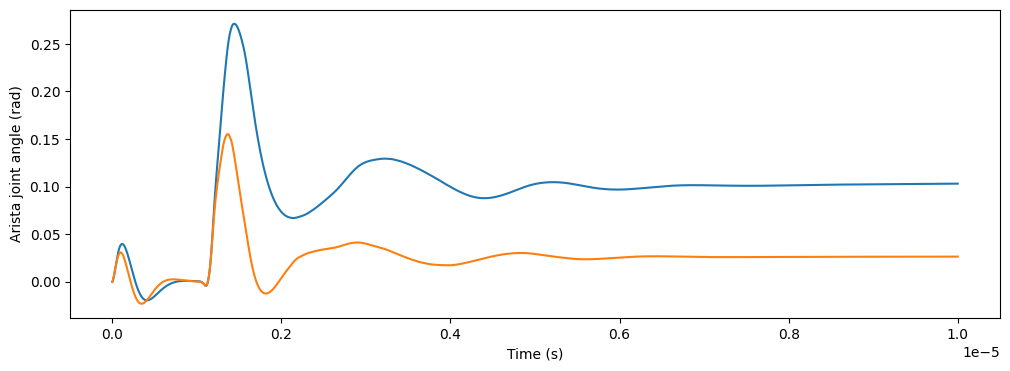

In [8]:
import matplotlib.pyplot as plt

arista_joint = np.array([obs["arista_joint_pos"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps) * arista_nmf.timestep
plt.figure(figsize=(12, 4))

plt.plot(time, arista_joint)
plt.xlabel("Time (s)")
plt.ylabel("Arista joint angle (rad)")
plt.show()

### Modifying the arena

The arenas are defined under flygym/mujoco/arena you can already find a ton of inspiration there. Here we will build an arena with a capsule in it's center half buried in the ground. From that we will inherit from the FlatTerrain.

In [9]:
from flygym.mujoco.arena import FlatTerrain


class CapsuleTerrain(FlatTerrain):
    def __init__(self):
        super().__init__()

        capsule = self.root_element.worldbody.add(
            "geom",
            type="capsule",
            name="ground_capsule",
            friction="1 0.005 0.0001",
            fromto="2.0 -1.0 0.0 2.0 1.0 0.0",
            size="0.5",
        )

        # Here you could also add collision groups to the capsule just like it is done in the NeuroMechFly class


caps_terr = CapsuleTerrain()

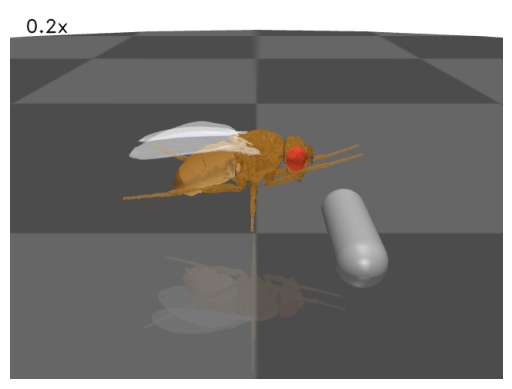

In [10]:
nmf = NeuroMechFly(
    Parameters(render_camera="Animat/camera_top_right"), arena=CapsuleTerrain()
)
obs = nmf.reset()
nmf.step({"joints": leg_action})
nmf.render()

plt.imshow(nmf._frames[-1], origin="upper")
plt.axis("off")
plt.show()

# Foraging the Mujoco documentation

When trying to implement new functionalities for NeuroMechFly one can rely on MuJoCo to provide the appropriate tools. The MuJoCo documentation is quite complete (at least for the cpp) version but is also very dense. Here is an example on how one can navigate it to implement wind in NeuroMechFly.

The first step is to check wether wind is already implemented in MuJoCo. A simple Ctrl+F in the [xml documentation](https://mujoco.readthedocs.io/en/stable/XMLreference.html#xml-reference) is in my opinion the best way to check for that.

<p align="center">
    <img src="source/xml_wind.png" width="600" style="background-color: white;"/>
</p>

At this stage it is very important to carefully read what the documentation says:

In particular, it is important to note that this wind implementation depends on the density and viscosity of the medium. Equally important is to notice where to instantiate the wind. By browsing the documentation you should get that this is done in the opt part of the physics. 

Now let's try to make the wind work. Here we have two options, add the wind in the xml or change it in the code. We will go for the second one as having a separate xml for wind seems not so practical.

In [11]:
class WindArena(FlatTerrain):
    def __init__(
        self,
        wind_vector=[-100.0, 0, 0],
        medium_density=0.01,
        medium_viscosity=0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self._add_wind(wind_vector, medium_density, medium_viscosity)

    def _add_wind(self, wind_vector, medium_density, medium_viscosity):
        # Here I directly change the fields of the xml option element
        self.root_element.option.__setattr__("density", medium_density)
        self.root_element.option.__setattr__("viscosity", medium_viscosity)
        self.root_element.option.__setattr__("wind", wind_vector)


wind_arena = WindArena()

In [12]:
wind_nmf = NeuroMechFly(arena=WindArena())

run_total_time = 0.5
target_num_steps = int(run_total_time / wind_nmf.timestep)

# run a simulation with wind
for i in range(target_num_steps):
    obs, reward, terminated, truncated, info = wind_nmf.step({"joints": leg_action})
    wind_nmf.render()

In [13]:
wind_nmf.save_video("wind.mp4", 0)

# Delving deeper into MuJoCo-NeuroMechFly interraction

Once the physics have been built, making changes to the model will have no more impact. Still some modifications can be made at runtime. This is done by interacting directly with the physics. Interacting with the physics object is particularly useful to debug the simulation or check that the changes you added have been properly implemented and are reflected as expected in the physics.
There is no great documentation explaining how to interact with the physics object. One can inspire from the [MuJoCo C++ API documentation](https://mujoco.readthedocs.io/en/stable/APIreference/APItypes.html#types) as they mostly have a python counterpart or directly from the very thin (look at tutorial.ipynb) [dm_control documentation](https://github.com/google-deepmind/dm_control) (the python wrapper we are using for MuJoCo).

One can access the equivalent of [mjModel](https://mujoco.readthedocs.io/en/stable/APIreference/APItypes.html#tymodelenums) through ```nmf.physics.model```
 
One can access the equivalent of [mjData](https://mujoco.readthedocs.io/en/stable/APIreference/APItypes.html#tydataenums) through ```nmf.physics.data```

Feel free to explore more how those different fields could be useful. Here are a few examples.

In [14]:
nmf = NeuroMechFly()

run_time = 0.2
target_num_steps = int(run_time / nmf.timestep)

for i in range(target_num_steps):
    obs, reward, terminated, truncated, info = nmf.step({"joints": leg_action})

# Get single contacts and locations
for c in nmf.physics.data.contact:
    geom1_name = nmf.physics.model.id2name(c.geom1, "geom")
    geom2_name = nmf.physics.model.id2name(c.geom2, "geom")
    print(f"Contact between {geom1_name} and {geom2_name} at exact position {c.pos}")

# Get joint angles whithout adding a sensor (please only use it to debug your code)
print(nmf.physics.named.data.qpos["Animat/joint_LFFemur"])

# Get the parameters of a joint
jnt = nmf.physics.model.jnt("Animat/joint_LFFemur")
print(jnt.stiffness, jnt.axis, nmf.physics.model.id2name(jnt.bodyid, "body"))

# Get the Head inertia
head_inertia = nmf.physics.named.model.body_inertia["Animat/Head"]
print(head_inertia)  # Diagonal inertia matrix

Contact between ground and Animat/LFTarsus5 at exact position [ 1.09361232  0.69942419 -0.00492624]
Contact between ground and Animat/LFTarsus5 at exact position [ 1.08530880e+00  6.80252417e-01 -3.69478022e-04]
Contact between ground and Animat/LFTarsus5 at exact position [ 1.08728937e+00  6.79546341e-01 -2.67793193e-04]
Contact between ground and Animat/LHTarsus5 at exact position [-1.99621462  0.59255246 -0.0028832 ]
Contact between ground and Animat/LMTarsus5 at exact position [-0.90653766  1.31884173 -0.00256492]
Contact between ground and Animat/LMTarsus5 at exact position [-9.05334259e-01  1.29697185e+00 -1.47083994e-04]
Contact between ground and Animat/RHTarsus5 at exact position [-1.99578919 -0.60159014 -0.00292581]
Contact between ground and Animat/RMTarsus5 at exact position [-0.90544033 -1.32801579 -0.00252241]
Contact between ground and Animat/RMTarsus5 at exact position [-9.04249894e-01 -1.30614654e+00 -1.01551075e-04]
Contact between ground and Animat/RFTarsus5 at exact

Please note that both data and model have a named option. Not all attribute or method are available through the named field but this allows to access some parameters through the body name instead of the id.

In [15]:
# Just have a look at
for i, field in enumerate(dir(nmf.physics.model) + dir(nmf.physics.data)):
    if i % 10 == 0:
        print()
    print(field, end=", ")


_HAS_DYNAMIC_ATTRIBUTES, __class__, __copy__, __delattr__, __dict__, __dir__, __doc__, __eq__, __format__, __ge__, 
__getattribute__, __getstate__, __gt__, __hash__, __init__, __init_subclass__, __le__, __lt__, __module__, __ne__, 
__new__, __reduce__, __reduce_ex__, __repr__, __setattr__, __setstate__, __sizeof__, __str__, __subclasshook__, __weakref__, 
_model, actuator, actuator_acc0, actuator_actadr, actuator_actlimited, actuator_actnum, actuator_actrange, actuator_biasprm, actuator_biastype, actuator_cranklength, 
actuator_ctrllimited, actuator_ctrlrange, actuator_dynprm, actuator_dyntype, actuator_forcelimited, actuator_forcerange, actuator_gainprm, actuator_gaintype, actuator_gear, actuator_group, 
actuator_length0, actuator_lengthrange, actuator_plugin, actuator_trnid, actuator_trntype, actuator_user, body, body_bvhadr, body_bvhnum, body_dofadr, 
body_dofnum, body_geomadr, body_geomnum, body_gravcomp, body_inertia, body_invweight0, body_ipos, body_iquat, body_jntadr, body_jntn